# Market Making with Reinforcement Learning

In [20]:
# Data Handling
import pandas as pd
import numpy as np

# Generic
from collections import defaultdict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym

# Custom Modules
from Libraries import environment as env
from Libraries import agents as ag
from Libraries import approximators as val_approx
from Libraries import tiling
from data.data_gen import DataGenerator

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Setup the training environment

In [21]:
dataset_offset = 15000
data_generator = DataGenerator('data/lob.csv', levels=1, horizon=301, sequential=False)
lob_data = data_generator[0]

In [22]:
# Create the environment
env = env.Case2MarketMakerEnv(
    lob_data=lob_data,
    horizon=300,
    phi_transorm=env.PhiTransform.PnL_asymm_dampened(-0.5),
)
initial_state = env.reset()
display(initial_state)

[array([0., 0., 0., 0.]),
 array([ 2.20810000e+02,  2.36000000e+02,  2.20720000e+02,  2.16000000e+02,
         2.20765000e+02,  9.00000000e-02, -2.00000000e-02, -4.42477876e-02,
        -2.00000000e+01, -9.05858641e-05,  4.37586396e-05,  4.16666667e+01])]

In [23]:
# Compute spaces bounds
agent_state_bounds = np.array([
    [-1e6, 1e6], # Inventory
    [0,2], # Spread
    [-1,5], # Theta_a
    [-1,5], # Theta_b
])
market_state_bounds = np.array([lob_data.min(axis=0), lob_data.max(axis=0)]).T * np.array([0.9, 1.1])
full_state_bounds = np.vstack([agent_state_bounds, market_state_bounds])

# Add action
action_bounds = np.array([-1, 9])
agent_state_bounds = np.vstack([agent_state_bounds, action_bounds])
market_state_bounds = np.vstack([market_state_bounds, action_bounds])
full_state_bounds = np.vstack([full_state_bounds, action_bounds])
boundaries = [agent_state_bounds, market_state_bounds, full_state_bounds]


# Define discretization parameters
n_tiles = 64
n_tilings = 16
offset = 0.17
n_weights = 1024

# Create value functions
states_dim = [1,2,3]
value_functions = [
    tiling.SparseTileEncodingApproximator(
        state_dim = state_dim,
        bounds = bounds,
        n_tiles = n_tiles,
        n_tilings = n_tilings,
        offset = offset,
        n_weights = n_weights,
    )
    for state_dim, bounds in zip(states_dim, boundaries)
]

# Create the linear combination of the two value functions
lctc_weights = np.array([0.6, 0.1, 0.3])
value_function = tiling.LCTC_ValueFunction(
    value_functions = value_functions,
    lctc_weights    = lctc_weights
)

In [24]:
# Define the agent
agent = ag.SarsaLambdaAgent(
    env=env,
    value_function=value_function,
    alpha=1e-3,
    gamma=0.99,
    epsilon=0.5,
    epsilon_decay=0.995, 
    epsilon_min=1e-4,
    el_decay = 0.96
)

n_scenarios = 10
n_episodes = 40
# Train the agent
train_rewards_raw, infos_raw = [], []
for i in tqdm(range(n_episodes)):
    idx = i % n_scenarios
    lob_data_scenario = data_generator[idx]
    env.lob_data = lob_data_scenario
    req, inf = agent.train(n_episodes=5)
    train_rewards_raw.append(req)
    infos_raw.append(inf)
# train_rewards, infos = agent.train(n_episodes=400)

  0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

Training:   0%|          | 0/5 [00:00<?, ?episode/s]

In [31]:
train_rewards = np.array(train_rewards_raw).mean(axis=1)

In [49]:
np.array(train_rewards_raw).shape

(40, 5)

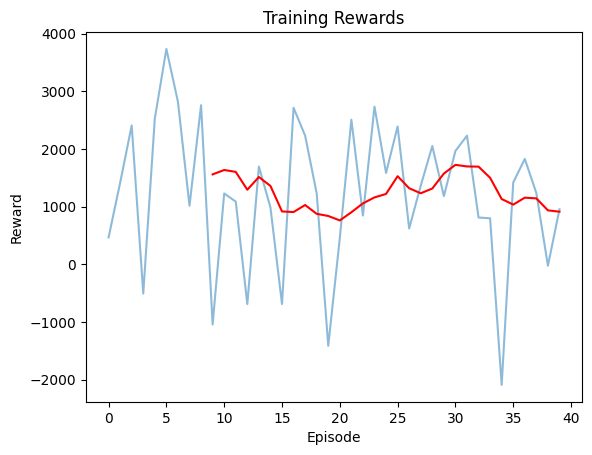

In [32]:
train_rewards_SMAs = pd.Series(train_rewards).rolling(window=10).mean()

plt.plot(train_rewards, alpha=0.5)
plt.plot(train_rewards_SMAs, color='red')
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [45]:
# Test the agent
test_rewards, test_infos = agent.test(n_episodes=10)
df_info = pd.DataFrame(test_infos[-1])

Testing:   0%|          | 0/10 [00:00<?, ?episode/s]

In [46]:
test_rewards.shape

(300,)

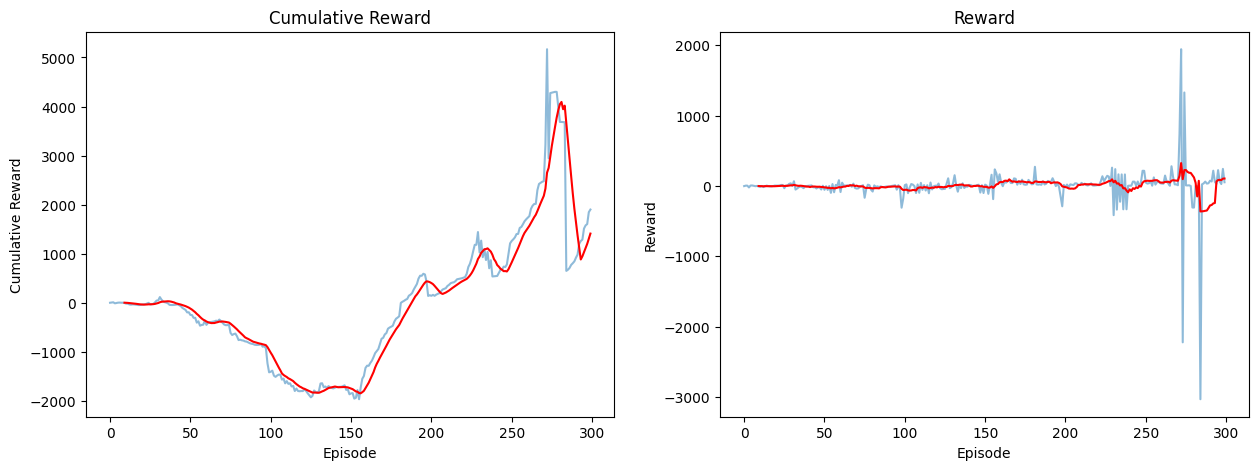

In [47]:
# Smooth the rewards
sma_window = 10
rewards_sma = pd.Series(test_rewards).rolling(window=sma_window).mean()

cumsum = np.cumsum(test_rewards)
cumsum_sma = np.cumsum(rewards_sma)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(cumsum, alpha=0.5)
ax[0].plot(cumsum_sma, color='red')
ax[0].set_title('Cumulative Reward')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Cumulative Reward')
ax[1].plot(test_rewards, alpha=0.5)
ax[1].plot(rewards_sma, color='red')
ax[1].set_title('Reward')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Reward')
fig.show()
